# Zero Truncation Extrapolation

Steps:
- use tilted field ising model
- visualization of truncation order
- determine convergence dependent on number of paulis strings
- path picture, frequency truncation
- look at coeff spectrum
- x axis pauli strings, y axis other truncation (such as min abs coeff?)

# Part 1 - Real Time Evolution

## Functions for real time evolution
- start param of exp matters! (1 for prob truncations, 0.01 for min abs coeff)
- set exact comp to 1e-6 value (to not crash the notebook)


In [1]:
include("zte_recap_1_functions.jl");
global_logger(UnbufferedLogger(stdout, SubInfo));

In [2]:
function trotter_tiltedising_setup(nqubits::Integer, steps::Integer, time::Float64, J::Float64, h::Float64; topology = bricklayertopology(nqubits))
    target_circuit = tiltedtfitrottercircuit(nqubits, steps; topology = topology)
    target_circuit_layer  = tiltedtfitrottercircuit(nqubits, 1; topology = topology)

    theta_J = -2 * time*J/steps # -2 * J * dt
    theta_h = 2 * time*h/steps # -2 * h * dt

    theta_J_indices = getparameterindices(target_circuit, PauliRotation, [:Z, :Z])

    theta_h_indices_Z = getparameterindices(target_circuit, PauliRotation, [:Z])
    theta_h_indices_X = getparameterindices(target_circuit, PauliRotation, [:X])

    #merge these two
    theta_h_indices = vcat(theta_h_indices_Z, theta_h_indices_X)

    theta_J_indices_layer = getparameterindices(target_circuit_layer, PauliRotation, [:Z, :Z])
    theta_h_indices_layer_Z = getparameterindices(target_circuit_layer, PauliRotation, [:Z])
    theta_h_indices_layer_X = getparameterindices(target_circuit_layer, PauliRotation, [:X])

    #merge these two
    theta_h_indices_layer = vcat(theta_h_indices_layer_Z, theta_h_indices_layer_X)
    
    return trotter_ansatz_tfim(
        target_circuit,
        target_circuit_layer,
        topology,
        nqubits,
        steps,
        time,
        J,
        h,
        theta_J,
        theta_h,
        theta_J_indices,
        theta_h_indices,
        theta_J_indices_layer,
        theta_h_indices_layer
    )
end


trotter_tiltedising_setup (generic function with 1 method)

In [3]:
function discard(array, threshold)
    """
    Discard the last part of the array if the relative difference between two consecutive elements is larger than threshold.
    Used to "detect" the "phase transition", distinguishing completly wrong result because of too much truncation
    from an approximate relevant result.
    """
    for i=1:length(array)-1
        if abs(array[i]-array[i+1])/abs(array[i])>threshold
            return array[1:i]            
        end
    end
    return array
end

discard (generic function with 1 method)

In [4]:
function truncateprobabilistically(
    pstr::PauliStringType, coeff, theta::Real, min_abs_coeff::Real, log
)
    """
    If the coefficient is absolutely smaller than the min_abs_coeff, we compare it to a random number drawn format
    an exponential distribution. If it is smaller, we discard it (i.e. truncate the term).
    This function comes with a fancy (but performance killer) logging system (if you uncomment the write line)
    to see how many truncations are performed and fine tuned the parameter (debugging purposes only ofc).
    """
    coeff_abs = abs(tonumber(coeff))
    rnd = rand(Exponential(min_abs_coeff*theta))
    if coeff_abs>=min_abs_coeff
        ans = false
    elseif coeff_abs>=min(rnd, 1.0)
        ans = false
    else
        ans = true
    end
    #str = format("{:.2e} {:.2e} {:.2e} {:.2e} {}\n", min_abs_coeff, min_abs_coeff*theta, coeff_abs, rnd, ans)
    # write(log, str)
    return ans
end

truncateprobabilistically (generic function with 1 method)

In [5]:
function expvals_trunc_levels(ansatz, trunc_type; observable = observable, trunc1=-6, trunc2=-1, threshold=0.01, n=50, gamma=0.01)
    """
    Runs simulations with a certain type of truncation at different levels.
    Arguments:
    - ansatz (trotter_ansatz_tfim struct): specify the parameters of the physical system of interest.
    - trunc_type (Symbol): specify the type of truncation.
    - trunc1 (int): specify the lowest level of truncation. If the truncation level is not an integer 
        (e.g. min_abs_coeff), it will be converted to 10^trunc1.
    - trunc2 (int): specify the highest level of truncation. If the truncation level is not an integer 
        (e.g. min_abs_coeff), it will be converted to 10^trunc2.
    - threshold (float): used in the function discard to detect the "phase transition" and decide which points
        are included in the fit.
    - n (int): number of truncation levels to try out.
    - gamma (float): I forgot. Joking. Iirc used in some personalized truncations.
    """
    if trunc_type==:min_abs_coeff || trunc_type==:truncatedampingcoeff || trunc_type==:truncateprobabilistically
        #trunc1 is lower bound, trunc2 is upper bound of min_abs_coeff truncation
        # n is the number of points in intervall, threshold is for the discard criteria 
        exponents = range(trunc1, trunc2, n)
        trunc_coeffs = 10.0 .^exponents
    else
        trunc_coeffs = trunc1:-1:trunc2
    end
    expvals = Vector{Float64}()   
    terms_nbr = Vector{Float64}()   
    for trunc_value in trunc_coeffs
        if trunc_type==:truncatedampingcoeff 
            truncategamma = (pstr, coeff) -> truncatedampingcoeff(
                pstr, coeff, gamma, trunc_value
            )
            kwargs = (; customtruncfunc=truncategamma)
        elseif trunc_type==:truncateprobabilistically 
        
            log = open("log_trunc.out", "a")
            truncategamma = (pstr, coeff) -> truncateprobabilistically(
                pstr, coeff, gamma, trunc_value, log
            )
            kwargs = (; customtruncfunc=truncategamma)
        else
            kwargs = (; trunc_type => trunc_value)
        end
        #record is false by default
        expval_t, terms_t = trotter_time_evolution(ansatz;observable = observable, return_fmt="countterms", kwargs...)
        push!(expvals, expval_t)
        push!(terms_nbr, terms_t)
    end
    clean_expvals = discard(expvals, threshold)
    clean_trunc_coeffs = trunc_coeffs[1:length(clean_expvals)]
    clean_terms_nbr = terms_nbr[1:length(clean_expvals)]

    return clean_terms_nbr, clean_trunc_coeffs, clean_expvals, terms_nbr, trunc_coeffs, expvals
end

expvals_trunc_levels (generic function with 1 method)

In [6]:
function correcting_single_truncations(ansatz, trunc_type::Vector{Symbol}=[:min_abs_coeff]; observable = nothing, 
    trunc1=[-6], trunc2=[-1], threshold=0.1e-3, abs_threshold=1e-6, plotting=false, n=50, gamma=0.01, mode="avg", exact = false)
    """
    Performs the simulations (calling expvals_trunc_levels) and correct the value. Can do some fancy plotting.
    Can either fit exponentially or linearly the data (mode="exp" or "lin") or average (mode="avg").
    """
    corrected_expvals = Dict()
    clean_trunc_coeffs = Dict()
    clean_terms_nbr = Dict()
    clean_expvals = Dict()
    trunc_coeffs = Dict()
    terms_nbr = Dict()
    expvals = Dict()

    if exact
        exact_expval = trotter_time_evolution(ansatz; observable = observable, min_abs_coeff = 1e-6, record = false)
    end 

    for (t, t1, t2) in zip(trunc_type, trunc1, trunc2)
        # println("$t $t1 $t2")
        clean_terms_nbr_tmp, clean_trunc_coeffs_tmp, clean_expvals_tmp, terms_nbr_tmp, trunc_coeffs_tmp, expvals_tmp = 
            expvals_trunc_levels(ansatz, t; observable = observable, trunc1=t1, trunc2=t2, threshold=threshold, n=n, gamma=gamma)
        println("clean_terms_nbr_tmp: ", clean_terms_nbr_tmp)
        println("clean_trunc_coeffs_tmp: ", clean_trunc_coeffs_tmp)
        println("clean_expvals_tmp: ", clean_expvals_tmp)
        
        # new filter: remove expvals below abs_threshold
        mask = clean_expvals_tmp .>= abs_threshold
        xdata = clean_terms_nbr_tmp[mask]
        println("xdata: ", xdata)
        ydata = clean_expvals_tmp[mask]
        println("ydata: ", ydata)
        xfit = range(minimum(xdata), maximum(xdata), length=200)

        if mode=="exp"

            modelexp(x,p) = p[1] .+ p[2] .* exp.(-p[3] .* x)
            p0 = [ydata[end], ydata[1] - ydata[end], 1]  # smaller initial rate

            fit = curve_fit(modelexp, xdata, ydata, p0)
            corrected_expval = modelexp(Inf, fit.param)
            println("corrected_expval: ", corrected_expval)
            yfit = modelexp.(xfit, Ref(fit.param))
            println("init params", p0)
            println("exp fit params: ", fit.param)

        # this was a bad idea
        elseif mode=="lin"
            modellin(x, p) = p[1] .+ p[2] .* x
            p0 = [ydata[end], (ydata[end]-ydata[1])]
            fit = curve_fit(modellin, xdata, ydata, p0)
            corrected_expval = modellin(Inf, fit.param)
            yfit = modellin.(xfit, Ref(fit.param))

        elseif mode=="avg"
            corrected_expval = mean(ydata)
        else
            println("what's mode=$mode? Average instead.")
            corrected_expval = mean(ydata)
        end

        #t is the truncation type
        corrected_expvals[t] = corrected_expval
        trunc_coeffs[t] = clean_trunc_coeffs_tmp
        clean_trunc_coeffs[t] = clean_trunc_coeffs_tmp[mask]
        terms_nbr[t] = terms_nbr_tmp
        clean_terms_nbr[t] = xdata
        clean_expvals[t] = ydata
        expvals[t] = expvals_tmp
    
        if exact
            println("exact_expval: ", exact_expval) #only print 2 digits after point
            println("corrected_expval: ", corrected_expval)
            println(format("absolute error corrected: {:.2e}", abs(exact_expval - corrected_expval) ) ) 
            println(format("absolute error of lowest truncation included: {:.2e}", abs(exact_expval - clean_expvals_tmp[1]) ))

            abs_error_last = abs(exact_expval - clean_expvals_tmp[1])
            abs_error_corr = abs(exact_expval - corrected_expval)
        end 
        
        if plotting
            mask_tmp = [terms_nbr_tmp[i]!=terms_nbr_tmp[i+1] for i in 1:length(terms_nbr_tmp)-1]
            push!(mask_tmp, true)
            
            expvals_tmp[expvals_tmp .== 0] .= 1e-16
            ydata[ydata .== 0] .= 1e-16
            terms_nbr_tmp[terms_nbr_tmp .== 0] .= 1e-1
            xdata[xdata .== 0] .= 1e-1
            
            p = plot(terms_nbr_tmp[mask_tmp], expvals_tmp[mask_tmp], markershape=:circle, label="Data not included\nin the fit", legend=:topright)
            
            mask_data = [xdata[i]!=xdata[i+1] for i in 1:length(xdata)-1]
            push!(mask_data, true)
            scatter!(xdata[mask_data], ydata[mask_data], markershape=:circle, label="Data included\nin the fit")
            if mode=="lin" || mode=="exp"
                plot!(xfit, yfit, label="ZTE fit $mode", lw=3, ls=:dash)
            else
                plot!(xfit, ones(200)*corrected_expval, line=:dash, lw=3, label="Averaged value")
            end

            xlabel!("number of terms in the Pauli sum")
            ylabel!("expectation value")
            title!("$(String(t)) (fit $mode)")
            display(p)
        end
    end
    
    return corrected_expvals, clean_trunc_coeffs, clean_expvals, trunc_coeffs, expvals
end


correcting_single_truncations (generic function with 2 methods)

## ZTE for TFIM (fit over number of Pauli strings)
- Just a check that this is worse for fitting than the subsequent tilted field Ising model.
- many `min_abs_coeff` values lead to same number of pauli string, so we get less data points, probably because the distribution is so easy to learn, either we find it or not
- using `truncateprobabilistically` has a significant overhead, but gives a smoother transition to work with

clean_terms_nbr_tmp: [65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 59.0, 59.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 21.0, 21.0, 21.0, 21.0, 21.0]
clean_trunc_coeffs_tmp: [0.0001, 0.00012067926406393288, 0.00014563484775012445, 0.00017575106248547912, 0.00021209508879201905, 0.0002559547922699536, 0.00030888435964774815, 0.00037275937203149417, 0.0004498432668969444, 0.0005428675439323859, 0.0006551285568595509, 0.0007906043210907702, 0.0009540954763499944, 0.0011513953993264468, 0.0013894954943731374, 0.0016768329368110084, 0.0020235896477251575, 0.0024420530945486523, 0.0029470517025518097, 0.0035564803062231283, 0.004291934260128779, 0.005179474679231213, 0.006250551925273976, 0.007543120063354615, 0.009102981779915217, 0.010985411419875584, 0.013257113655901088]
clean_expvals_tmp: [0.8549309179546772, 0.8549309179546772, 0.8549519155477643, 0.8549519155477643, 0.8549519155477643, 0.8549519155477643, 0.8549746860824015, 0.8549746860824015, 0.8549

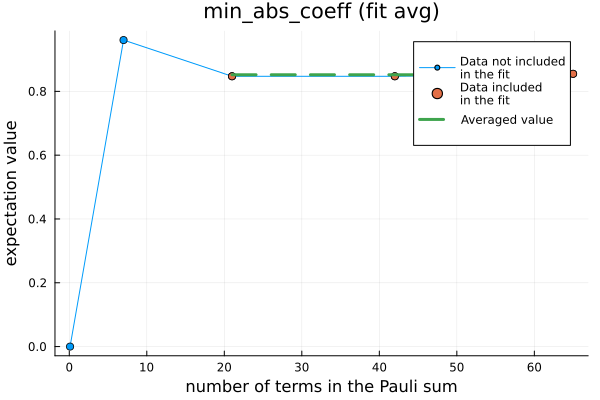

In [7]:
nq = 8
nl = 4

h = 1.0
J = 1.0

dt = 0.05
trotter = trotter_setup(nq, nl, dt*nl, J,h)
correcting_single_truncations(trotter, [:min_abs_coeff]; trunc1=[-4], trunc2=[-0], threshold = 1e-1, n = 50,plotting=true, mode="avg", exact = true);


clean_terms_nbr_tmp: [79.0, 78.0, 77.0, 77.0, 77.0, 76.0, 74.0, 74.0, 74.0, 72.0, 73.0, 72.0, 69.0, 66.0, 67.0, 68.0, 65.0, 67.0, 63.0, 63.0, 61.0, 59.0, 63.0, 60.0, 58.0, 58.0, 55.0, 57.0, 55.0, 52.0, 54.0, 51.0, 50.0, 50.0, 49.0, 45.0, 47.0, 45.0, 43.0, 39.0, 35.0, 33.0, 32.0, 26.0, 21.0, 14.0, 18.0, 14.0, 13.0, 9.0]
clean_trunc_coeffs_tmp: [0.001, 0.0011513953993264468, 0.0013257113655901094, 0.0015264179671752333, 0.0017575106248547913, 0.0020235896477251575, 0.002329951810515372, 0.0026826957952797246, 0.0030888435964774815, 0.0035564803062231283, 0.004094915062380423, 0.004714866363457394, 0.005428675439323859, 0.006250551925273976, 0.0071968567300115215, 0.008286427728546842, 0.009540954763499945, 0.010985411419875584, 0.012648552168552958, 0.014563484775012436, 0.016768329368110083, 0.019306977288832506, 0.022229964825261943, 0.025595479226995357, 0.029470517025518114, 0.03393221771895328, 0.03906939937054617, 0.044984326689694466, 0.0517947467923121, 0.05963623316594643, 0.068

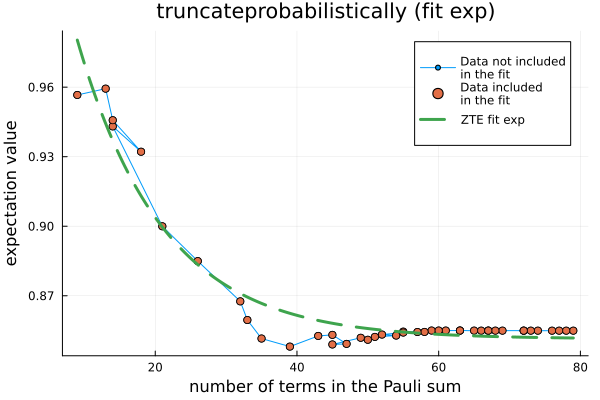

In [8]:
correcting_single_truncations(trotter, [:truncateprobabilistically]; trunc1=[-3], trunc2=[0], threshold = 1, plotting=true, mode="exp", exact = true);

## ZTE for tilted Hamiltonian (fit over number of Pauli strings)

In [9]:
#test the tilted setup
nq = 32
nl = 15

h = 1.0
J = 1.0

dt = 0.05
tilted = trotter_tiltedising_setup(nq, nl, dt*nl, J,h)

trotter_ansatz_tfim(Gate[PauliRotation([:Z, :Z], [1, 2]), PauliRotation([:Z, :Z], [3, 4]), PauliRotation([:Z, :Z], [5, 6]), PauliRotation([:Z, :Z], [7, 8]), PauliRotation([:Z, :Z], [9, 10]), PauliRotation([:Z, :Z], [11, 12]), PauliRotation([:Z, :Z], [13, 14]), PauliRotation([:Z, :Z], [15, 16]), PauliRotation([:Z, :Z], [17, 18]), PauliRotation([:Z, :Z], [19, 20])  …  PauliRotation([:X], [23]), PauliRotation([:X], [24]), PauliRotation([:X], [25]), PauliRotation([:X], [26]), PauliRotation([:X], [27]), PauliRotation([:X], [28]), PauliRotation([:X], [29]), PauliRotation([:X], [30]), PauliRotation([:X], [31]), PauliRotation([:X], [32])], Gate[PauliRotation([:Z, :Z], [1, 2]), PauliRotation([:Z, :Z], [3, 4]), PauliRotation([:Z, :Z], [5, 6]), PauliRotation([:Z, :Z], [7, 8]), PauliRotation([:Z, :Z], [9, 10]), PauliRotation([:Z, :Z], [11, 12]), PauliRotation([:Z, :Z], [13, 14]), PauliRotation([:Z, :Z], [15, 16]), PauliRotation([:Z, :Z], [17, 18]), PauliRotation([:Z, :Z], [19, 20])  …  PauliRotati

### Average and exponential extrapolations (linear does not work)

clean_terms_nbr_tmp: [4292.0, 3978.0, 3502.0, 3129.0, 2725.0, 2375.0, 2003.0, 1565.0]
clean_trunc_coeffs_tmp: [0.0001, 0.00012067926406393288, 0.00014563484775012445, 0.00017575106248547912, 0.00021209508879201905, 0.0002559547922699536, 0.00030888435964774815, 0.00037275937203149417]
clean_expvals_tmp: [0.09476965927217865, 0.09141667171524558, 0.09025633665616796, 0.08149236183945943, 0.08601954965885189, 0.09125814515665139, 0.09077108993207555, 0.08696260131870089]
xdata: [4292.0, 3978.0, 3502.0, 3129.0, 2725.0, 2375.0, 2003.0, 1565.0]
ydata: [0.09476965927217865, 0.09141667171524558, 0.09025633665616796, 0.08149236183945943, 0.08601954965885189, 0.09125814515665139, 0.09077108993207555, 0.08696260131870089]


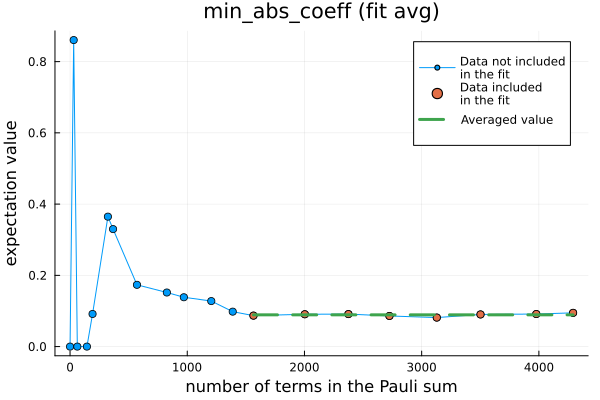

In [10]:
correcting_single_truncations(tilted, [:min_abs_coeff]; trunc1=[-4], trunc2=[0], threshold = 1e-1, plotting=true, mode="avg", exact = false);

clean_terms_nbr_tmp: [4292.0, 3978.0, 3502.0, 3129.0, 2725.0, 2375.0, 2003.0, 1565.0]
clean_trunc_coeffs_tmp: [0.0001, 0.00012067926406393288, 0.00014563484775012445, 0.00017575106248547912, 0.00021209508879201905, 0.0002559547922699536, 0.00030888435964774815, 0.00037275937203149417]
clean_expvals_tmp: [0.09476965927217865, 0.09141667171524558, 0.09025633665616796, 0.08149236183945943, 0.08601954965885189, 0.09125814515665139, 0.09077108993207555, 0.08696260131870089]
xdata: [4292.0, 3978.0, 3502.0, 3129.0, 2725.0, 2375.0, 2003.0, 1565.0]
ydata: [0.09476965927217865, 0.09141667171524558, 0.09025633665616796, 0.08149236183945943, 0.08601954965885189, 0.09125814515665139, 0.09077108993207555, 0.08696260131870089]
corrected_expval: 0.08911830194357832
init params[0.08696260131870089, 0.007807057953477761, 1.0]
exp fit params: [0.08911830194357832, 0.007807057953477761, 1.0]
exact_expval: 0.09285850603017355
corrected_expval: 0.08911830194357832
absolute error corrected: 3.74e-03
absolute

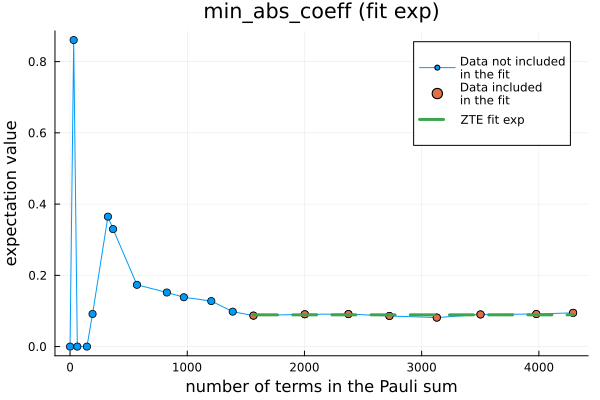

In [11]:
correcting_single_truncations(tilted, [:min_abs_coeff]; trunc1=[-4], trunc2=[0], threshold = 1e-1, plotting=true, mode="exp", exact = true);

Comments:
- Q: why does prob truncations run ages for tilted TFIM
- fit only before convergence, otherwise no improvement of extrapolation
- thus exponential makes no sense because we need convergence already to fit it
- average would assume our values fluctuate equally around the target expecatation value, but we don't necessarily fluctuate around the zero truncation value, more often than not we approach it from one side
- comp effort should be lower than computing a lower truncation order (exponentially more terms per truncation order, if we have a factor n of terms of higher order, is this faster than running one simulation at a lower truncation order?)

# Part 2 - Imaginary Time Evolution

## Functions for ITE

In [ ]:
function run_or_read(model, layer, nq, nl, tstep, obs_i, obs_j, max_weight, min_abs_coeff; run=false)
    """
    It's in the title. Run the simulation or use existing data if present. 
    """
    fn = format("data/{}_nq={:d}_nl={:d}_theta={:.3e}_obsi={:d}_obsj={:d}_maxweight={:d}_minabscoeff={:.4e}_termcount.dat", model, nq, nl, tstep, obs_i, obs_j, max_weight, min_abs_coeff)
    expectation = 0
    terms_nbr = 0
    observable = PauliString(nq, [:Z,:Z], [obs_i,obs_j]);
    time = range(tstep, tstep*nl, nl)
    try
        @assert run==false
        open(fn, "r") do log
            data = CSV.read(log, DataFrame)
            time_file = data[:,1]
            expectation = data[:,2]
            terms_nbr = data[:,3]
        end
    catch e
        expectation, terms_nbr = thermalStateExpectation(layer, nl, nq, observable; min_abs_coeff=min_abs_coeff, max_weight=max_weight, return_fmt="countterms")
        data = DataFrame(time=time, expectation=expectation, terms_nbr=terms_nbr)
        CSV.write(fn, data)
    end
    return expectation, terms_nbr
end

run_or_read (generic function with 1 method)

In [ ]:
# for some reason I recoded some new functions, we'll do something cleaner if needed

function zte_exp(expvals, terms_nbr, times; plotting=true, exact_expvals=nothing, abs_threshold=1e-16, fn="")
    try
        @assert length(expvals)==length(terms_nbr)
    catch e
        error("The length of input arguments don't match (length(expvals)=$(length(expvals)), length(terms_nbr)=$(length(terms_nbr)))")
    end
    corrected_expvals = Vector{Float64}()
    for idx=1:length(expvals[1])
        expvals_t = [row[idx] for row in expvals]
        terms_nbr_t = [row[idx] for row in terms_nbr]
        println("expvals_t: ", expvals_t)
        println("terms_nbr_t: ", terms_nbr_t)

        # data = DataFrame(trunc=terms_nbr, expval=expvals_t)
        push!(corrected_expvals, exp_offset_logfit(terms_nbr_t, expvals_t; abs_threshold=abs_threshold, fn="plot_fits/"*fn*"_step=$idx.png"))
    end

    @logmsg SubInfo "corrected_expvals: $corrected_expvals"
    if plotting
        truncated_most_precise = expvals[end]
        try
            @assert length(times)==length(corrected_expvals)==length(truncated_most_precise)
        catch e
            error("The lengths don't match for plotting (length(times)=$(length(times)), length(corrected_expvals)=$(length(corrected_expvals)))")
        end
        corrected_expvals_cleaned = replace_zeros(corrected_expvals)
        truncated_most_precise_cleaned = replace_zeros(truncated_most_precise)
        p = plot(times, corrected_expvals_cleaned, label="corrected", marker=:circle)
        plot!(times, truncated_most_precise_cleaned, label="truncated most precise", marker=:circle)
        # plot!(yscale=:log10)
        xlabel!("Time")
        ylabel!("Observable")
        title!("Evolution over time")
        if exact_expvals!=nothing
            exact_expvals_cleaned = replace_zeros(exact_expvals)
            # plot!(times, exact_expvals_cleaned, label="exact", marker=:circle)
            rel_err_corr = replace_zeros(abs.((corrected_expvals-exact_expvals)./exact_expvals))
            q = plot(times, rel_err_corr, label="corrected", marker=:circle)
            rel_err_most_prec = replace_zeros(abs.((truncated_most_precise-exact_expvals)./exact_expvals))
            plot!(times, rel_err_most_prec, label="truncated most precise", marker=:circle)
            plot!(yscale=:log10)
            xlabel!("Timestep")
            ylabel!("Relative error")
            title!("Evolution over time")
            display(q)
        end
        display(p)
    end
    return corrected_expvals
end

# works but bad
function exp_fit(xdata, ydata; abs_threshold=1e-16, fn="")
    mask = xdata .>= abs_threshold
    xdata = xdata[mask]
    ydata = ydata[mask]
    model(x, p) = p[1] .+ p[2] .* exp.(-p[3] .* x)
    p0 = [ydata[end], ydata[1] - ydata[end], 0.01] # initial guess matters!
    @logmsg SubInfo "initial parameters exp fit $p0 "
    # smaller initial rate
    fit = curve_fit(model, xdata, ydata, p0)
    @logmsg SubInfo "exp fit params: $fit.param"
    if fn!=""
        scatter(xdata, ydata, label="data", marker=:circle)
        array = range(minimum(xdata), maximum(xdata), 50)
        plot!(array, model(array, fit.param), label="fit")
        if minimum(xdata)<1
            plot!(xscale=:log10)
        end
        title = match(r"step=\d+", fn)
        title!(title.match)
        xlabel!("truncation level")
        ylabel!("expectation value")
        savefig(fn)
    end

    return model(0.0, fit.param)
end

#works but good
function exp_offset_logfit(xdata, ydata; abs_threshold=1e-16, fn="")
    # 1) mask out too‐small x
    mask = xdata .>= abs_threshold
    x = xdata[mask]; y = ydata[mask]

    # 2) estimate asymptotic plateau A from largest x
    A = y[end]

    # 3) form residuals for a rising‐to‐plateau model: y = A − B e^(−C x)
    y_adj = A .- y
    pos   = y_adj .> 0
    if !any(pos)
        @logmsg SubInfo "No positive residuals after baseline subtraction; returning A."
        return A
    end
    x2 = x[pos]; y2 = y_adj[pos]

    # 4) linearize: ln(A−y) = ln B − C x
    logy2 = log.(y2)
    model(x, p) = p[1] .- p[2] .* x      # p[1]=ln B, p[2]=C
    p0 = [logy2[1], 1e-3]
    @logmsg SubInfo "init log‐fit params $p0"
    fit = curve_fit(model, x2, logy2, p0)
    lnB, C = fit.param; B = exp(lnB)
    @logmsg SubInfo "fit results: A=$A, B=$B, C=$C"

    # 5) optional plotting
    if fn != ""
        scatter(x, y, label="data", marker=:circle)
        array = range(minimum(x), maximum(x), 50)
        plot!(array, A .- B .* exp.(-C .* array), label="fit")
        if minimum(x) < 1; plot!(xscale=:log10); end
        #if m = match(r"step=\d+", fn); title!(m.match); end
        title = match(r"step=\d+", fn)
        xlabel!("truncation level"); ylabel!("expectation value")
        savefig(fn)
    end

    # extrapolated value at x=0: y(0) = A − B
    return A - B
end



function replace_zeros(vec, val=1e-16)
    vec[abs.(vec).<=val] .= val
    return vec
end

replace_zeros (generic function with 2 methods)

## XX-Z Hamiltonian
- the data is already generated (runs fast)
- problem: in Andrew's plots, we looked at absolute error, there the truncation orders are well separated
- when looking at just the expecatation value over time, there is no such clean separation

In [ ]:
function xxz_circuit(nqubits::Integer, steps::Integer; topology = bricklayertopology(nqubits))
    """
    Returns a circuit for the XXZ model with nqubits and steps. 
    """
    #rxxlayer!(circuit, topology) = append!(circuit, (PauliRotation([:X, :X], pair) for pair in topology))
    #rzlayer!(circuit, nqubits) = append!(circuit, (PauliRotation(:Z, ii) for ii in 1:nqubits))
    
    circuit::Vector{Gate} = []

    for _ in 1:steps
        rxxlayer!(circuit, topology)
        rzlayer!(circuit, nqubits)
    end

    return circuit

end

xxz_circuit (generic function with 1 method)

In [ ]:
#init struct for the XX-Z Hamiltonian
# not sure about the sign of h here (keep consistent with the exact solution, so -h)
function xxz_trotter_setup(nqubits::Integer, steps::Integer, time::Float64, J::Float64, h::Float64;topology = nothing)
    if isnothing(topology)
        topology = bricklayertopology(nqubits)
    end
    target_circuit = xxz_circuit(nqubits,steps,topology=topology) #starts with RZZ layer
    target_circuit_layer = xxz_circuit(nqubits,1,topology=topology) #starts with RZZ layer
    
    
    sigma_J = -2*time*J/steps
    sigma_h = -2*time*h/steps 

    sigma_J_indices = getparameterindices(target_circuit, PauliRotation, [:X,:X]) 
    sigma_h_indices = getparameterindices(target_circuit, PauliRotation, [:Z])
    
    sigma_J_indices_layer = getparameterindices(target_circuit_layer, PauliRotation, [:X,:X])
    sigma_h_indices_layer = getparameterindices(target_circuit_layer, PauliRotation, [:Z])
    
    return trotter_ansatz_tfim(target_circuit,target_circuit_layer, topology, nqubits, steps, time, J, h,sigma_J, sigma_h,sigma_J_indices, sigma_h_indices, sigma_J_indices_layer, sigma_h_indices_layer)
end


xxz_trotter_setup (generic function with 1 method)

In [ ]:
nq = 30
nl = 20
dt = 0.05
J = 5.0
h = 1.0
xxz_circ = xxz_circuit(nq, nl)
println(xxz_circ)
xxz = xxz_trotter_setup(nq, nl, dt*nl, J, h)

Gate[PauliRotation([:X, :X], [1, 2]), PauliRotation([:X, :X], [3, 4]), PauliRotation([:X, :X], [5, 6]), PauliRotation([:X, :X], [7, 8]), PauliRotation([:X, :X], [9, 10]), PauliRotation([:X, :X], [11, 12]), PauliRotation([:X, :X], [13, 14]), PauliRotation([:X, :X], [15, 16]), PauliRotation([:X, :X], [17, 18]), PauliRotation([:X, :X], [19, 20]), PauliRotation([:X, :X], [21, 22]), PauliRotation([:X, :X], [23, 24]), PauliRotation([:X, :X], [25, 26]), PauliRotation([:X, :X], [27, 28]), PauliRotation([:X, :X], [29, 30]), PauliRotation([:X, :X], [2, 3]), PauliRotation([:X, :X], [4, 5]), PauliRotation([:X, :X], [6, 7]), PauliRotation([:X, :X], [8, 9]), PauliRotation([:X, :X], [10, 11]), PauliRotation([:X, :X], [12, 13]), PauliRotation([:X, :X], [14, 15]), PauliRotation([:X, :X], [16, 17]), PauliRotation([:X, :X], [18, 19]), PauliRotation([:X, :X], [20, 21]), PauliRotation([:X, :X], [22, 23]), PauliRotation([:X, :X], [24, 25]), PauliRotation([:X, :X], [26, 27]), PauliRotation([:X, :X], [28, 29]

trotter_ansatz_tfim(Gate[PauliRotation([:X, :X], [1, 2]), PauliRotation([:X, :X], [3, 4]), PauliRotation([:X, :X], [5, 6]), PauliRotation([:X, :X], [7, 8]), PauliRotation([:X, :X], [9, 10]), PauliRotation([:X, :X], [11, 12]), PauliRotation([:X, :X], [13, 14]), PauliRotation([:X, :X], [15, 16]), PauliRotation([:X, :X], [17, 18]), PauliRotation([:X, :X], [19, 20])  …  PauliRotation([:Z], [21]), PauliRotation([:Z], [22]), PauliRotation([:Z], [23]), PauliRotation([:Z], [24]), PauliRotation([:Z], [25]), PauliRotation([:Z], [26]), PauliRotation([:Z], [27]), PauliRotation([:Z], [28]), PauliRotation([:Z], [29]), PauliRotation([:Z], [30])], Gate[PauliRotation([:X, :X], [1, 2]), PauliRotation([:X, :X], [3, 4]), PauliRotation([:X, :X], [5, 6]), PauliRotation([:X, :X], [7, 8]), PauliRotation([:X, :X], [9, 10]), PauliRotation([:X, :X], [11, 12]), PauliRotation([:X, :X], [13, 14]), PauliRotation([:X, :X], [15, 16]), PauliRotation([:X, :X], [17, 18]), PauliRotation([:X, :X], [19, 20])  …  PauliRotati

In [ ]:
model = "TFIM"

theta = 0.01im
θ = theta

topology = bricklayertopology(nq)

# the circuit
circuitTFIM = Gate[]
for i in 1:nl
    append!(circuitTFIM, PauliRotation(:Z, ii, θ) for ii in 1:nq);
    append!(circuitTFIM, PauliRotation([:X, :X], pair, θ) for pair in topology);
end

# system parameters
obs_i = 21
obs_j = 20
observable = PauliString(nq, [:Z,:Z], [obs_i,obs_j])

# max_weight = 12
max_weight = 9
# range -10 to -20 is already generated for nl=20, nq=30
trunc_coeffs = 2.0 .^ (-12:-1:-16)

tstep = 0.01
time = range(tstep, tstep*nl, nl)

fn = format("{}_nq={:d}_nl={:d}_theta={:.3e}_obsi={:d}_obsj={:d}_maxweight={:d}", model, nq, nl, tstep, obs_i, obs_j, max_weight)    

# initialize the plot
scatter(ylabel=L"$\langle Z_{20}Z_{21} \rangle$", xlabel=L"time", title = L"$H = \sum_{i=1} -Z_i - X_iX_{i+1}$")

# exact expectation values calculations
M = jordan_wigner_tfim(nq, 1.0, 0.0, 1.0) # nq, Jx,Jy, h
zz = zeros(length(time))
for i in 1:length(time)
    zz[i] = zz_correlation(M, time[i], obs_i, obs_j)
end

# get truncated expectation values
expvals = Vector{Vector{Float64}}()
terms_nbrs = Vector{Vector{Float64}}()
for j in trunc_coeffs
    expectation, terms_nbr = run_or_read("TFIM", circuitTFIM, nq, nl, tstep, obs_i, obs_j, max_weight, j)
    expectation[expectation .== 0] .= 1e-16
    
    #plot last 5 values
    plot!(time, expectation, label = L"$2^{%$(round(log2(j), digits=2))}$", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)
    push!(expvals, expectation)
    push!(terms_nbrs, terms_nbr)
end
#plot!(yscale=:log10)
plot!(time, zz, label = "exact", color="red", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)


display(scatter!())
#delete the first n values of every nested vector in expvals and terms_nbrs
zte_exp(expvals, terms_nbrs, time; exact_expvals=zz, fn=fn);

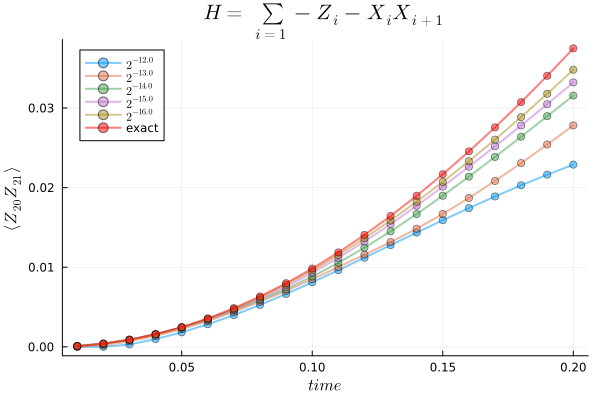

expvals_t: [1.0e-16, 1.0e-16, 9.99933337110914e-5, 9.99933337110914e-5, 9.99933337110914e-5]
terms_nbr_t: [60.0, 60.0, 1713.0, 1713.0, 1713.0]
[SubInfo] init log‐fit params [-9.210407037088338, 0.001]
[SubInfo] fit results: A=9.99933337110914e-5, B=0.00010303858408760051, C=0.0004999999999988049
expvals_t: [1.0e-16, 0.0001991816029934167, 0.00039868525535552847, 0.00039868525535552847, 0.00039868525535552847]
terms_nbr_t: [60.0, 1713.0, 1713.0, 1713.0, 1713.0]
[SubInfo] init log‐fit params [-7.827338286063095, 0.001]
[SubInfo] fit results: A=0.00039868525535552847, B=0.0004088312873457915, C=0.00041883831104628697
expvals_t: [0.00029642939904182955, 0.0006915330879369289, 0.0008915257150859551, 0.0008915257150859551, 0.0008915257150859551]
terms_nbr_t: [1713.0, 1713.0, 1713.0, 1713.0, 1713.0]
[SubInfo] init log‐fit params [-7.42678728981469, 0.001]
[SubInfo] fit results: A=0.0008915257150859551, B=0.0010670067490234413, C=0.0006591422601487956
expvals_t: [0.0009753882133803827, 0.00136

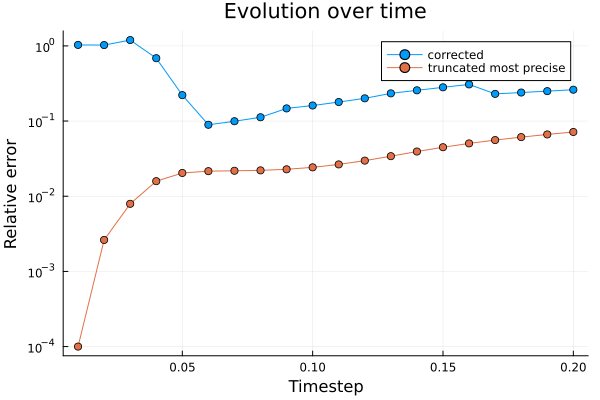

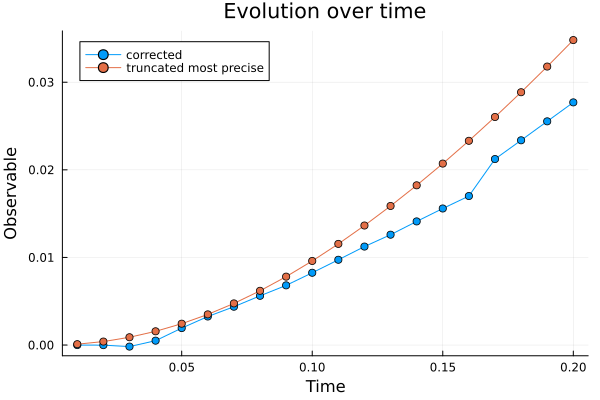

In [18]:
model = "TFIM"

theta = 0.01im
θ = theta

topology = bricklayertopology(nq)

# the circuit
circuitTFIM = Gate[]
for i in 1:nl
    #append!(circuitTFIM, PauliRotation(:X, ii, θ) for ii in 1:nq);
    append!(circuitTFIM, PauliRotation(:Z, ii, θ) for ii in 1:nq);
    append!(circuitTFIM, PauliRotation([:X, :X], pair, θ) for pair in topology);
end

# system parameters
obs_i = 21
obs_j = 20
observable = PauliString(nq, [:Z,:Z], [obs_i,obs_j])

# max_weight = 12
max_weight = 9
# range -10 to -20 is already generated for nl=20, nq=30
trunc_coeffs = 2.0 .^ (-12:-1:-16)

tstep = 0.01
time = range(tstep, tstep*nl, nl)

fn = format("{}_nq={:d}_nl={:d}_theta={:.3e}_obsi={:d}_obsj={:d}_maxweight={:d}", model, nq, nl, tstep, obs_i, obs_j, max_weight)    

# initialize the plot
scatter(ylabel=L"$\langle Z_{20}Z_{21} \rangle$", xlabel=L"time", title = L"$H = \sum_{i=1} -Z_i - X_iX_{i+1}$")

# exact expectation values calculations
M = jordan_wigner_tfim(nq, 1.0, 0.0, 1.0) # nq, Jx,Jy, h
zz = zeros(length(time))
for i in 1:length(time)
    zz[i] = zz_correlation(M, time[i], obs_i, obs_j)
end

# get truncated expectation values
expvals = Vector{Vector{Float64}}()
terms_nbrs = Vector{Vector{Float64}}()
for j in trunc_coeffs
    expectation, terms_nbr = run_or_read("TFIM", circuitTFIM, nq, nl, tstep, obs_i, obs_j, max_weight, j)
    expectation[expectation .== 0] .= 1e-16
    
    #plot last 5 values
    plot!(time, expectation, label = L"$2^{%$(round(log2(j), digits=2))}$", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)
    push!(expvals, expectation)
    push!(terms_nbrs, terms_nbr)
end
#plot!(yscale=:log10)
plot!(time, zz, label = "exact", color="red", legend=:topleft, lw=2, markersize=4, marker=:circle, alpha=0.5)


display(scatter!())
#delete the first n values of every nested vector in expvals and terms_nbrs
zte_exp(expvals, terms_nbrs, time; exact_expvals=zz, fn=fn);

With the log data fit this works quite well, but we still can't get below the truncated most precise values if we want a good fit.